# Flood Prediction Dataset Pipeline: Valencia DANA 2024 Case Study

This notebook uses the `gee_pipeline` module to generate a dataset for the **Valencia DANA flood event (October 2024)**.

## Visualized Layers Explanation
1.  **Sentinel-2 RGB**: Standard visual color image (Red, Green, Blue bands).
2.  **MNDWI (Modified Normalized Difference Water Index)**: Uses Green and SWIR bands. Better for scanning turbid (muddy) water than standard NDWI.
3.  **Sentinel-1 VV**: SAR (Radar) backscatter in Decibels (dB). Water usually appears dark.
4.  **Flood Label (Weak)**: A preliminary mask generated automatically using MNDWI threshold.

In [ ]:
# ==========================================
# IMPORTS & SETUP
# ==========================================
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import ee
import geemap

from gee_pipeline import get_sentinel2_data, get_sentinel1_data, fuse_datasets, add_weak_labels, download_tile, download_patches

# Authenticate and Initialize
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

/home/chatarra/Documents/Uni/4º/TFG/.venv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


Authenticating Earth Engine...


In [ ]:
# ==========================================
# 1. DEFINE PARAMETERS (Valencia DANA 2024)
# ==========================================

start_date = '2024-10-25'
end_date   = '2024-11-05'

# Defines ROI (Valencia / Albufera region)
roi_coords = [
  [-0.5925608219299572, 39.05499447698859], 
  [-0.08444314614870718, 39.05499447698859], 
  [-0.08444314614870718, 39.48875100708455], 
  [-0.5925608219299572, 39.48875100708455], 
  [-0.5925608219299572, 39.05499447698859]
]
roi = ee.Geometry.Polygon(roi_coords)

# Visualize ROI
Map = geemap.Map()
Map.centerObject(roi, 9)
Map.addLayer(roi, {'color': 'red'}, 'ROI')
Map

Map(center=[39.271925006860656, -0.3385019840396818], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
# ==========================================
# 2. FETCH DATA
# ==========================================

# Get Sentinel-2 Data (now includes MNDWI)
s2_data = get_sentinel2_data(roi, start_date, end_date)

# Get Sentinel-1 Data
s1_data = get_sentinel1_data(roi, start_date, end_date)

print("Collections filtered.")
print(f"S2 images: {s2_data.size().getInfo()}")
print(f"S1 images: {s1_data.size().getInfo()}")

Collections filtered.
S2 images: 5
S1 images: 7


In [ ]:
# ==========================================
# 3. FUSE SENTINEL-1 & SENTINEL-2
# ==========================================

fused_dataset = fuse_datasets(s2_data, s1_data, roi, start_date, end_date)

# Add Weak Labels (Flood Proxy using MNDWI)
# Adjustable threshold: 0.0 is standard, sometimes -0.2 includes more mud.
labeled_dataset = fused_dataset.map(lambda img: add_weak_labels(img, threshold=0.0))

print("Data fused and labeled.")
count = labeled_dataset.size().getInfo()
print(f"Fused images (coincident S1 & S2): {count}")

Data fused and labeled.
Fused images (coincident S1 & S2): 2


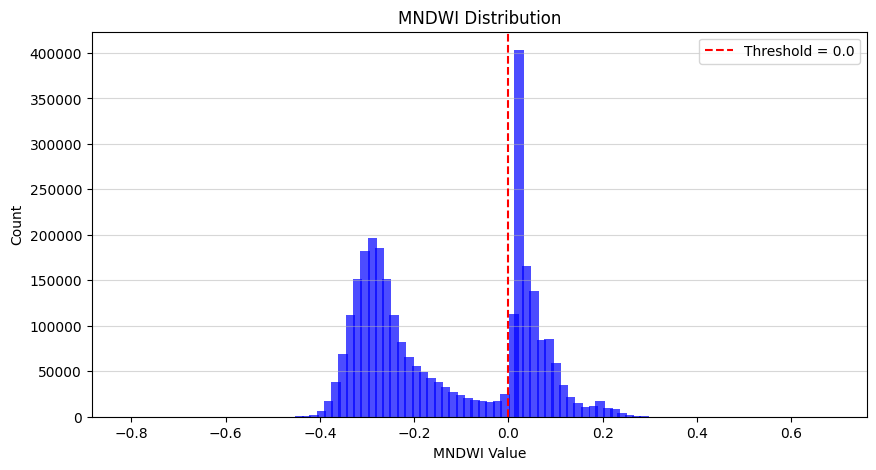

If bimodal (two peaks), the threshold should be between them.


In [ ]:
# ==========================================
# 4. HISTOGRAM ANALYSIS
# ==========================================

if count > 0:
    example_image = labeled_dataset.first()
    
    # Compute histogram for MNDWI to check distribution
    hist = example_image.select('S2_MNDWI').reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=100),
        geometry=roi,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    if 'S2_MNDWI' in hist:
        values = hist['S2_MNDWI']['bucketMeans']
        counts = hist['S2_MNDWI']['histogram']
        
        plt.figure(figsize=(10, 5))
        plt.bar(values, counts, width=0.02, color='blue', alpha=0.7)
        plt.axvline(x=0.0, color='red', linestyle='--', label='Threshold = 0.0')
        plt.title("MNDWI Distribution")
        plt.xlabel("MNDWI Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(axis='y', alpha=0.5)
        plt.show()
        print("If bimodal (two peaks), the threshold should be between them.")

In [ ]:
# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================

if count > 0:
    # Reuse example_image from above or get first
    example_image = labeled_dataset.first()
    date_str = example_image.get('date').getInfo()
    print(f"Visualizing image for date: {date_str}")

    vis_s2 = {'bands': ['S2_B4', 'S2_B3', 'S2_B2'], 'min': 0, 'max': 3000}
    vis_mndwi = {'bands': ['S2_MNDWI'], 'min': -0.5, 'max': 0.5, 'palette': ['brown', 'white', 'blue']}
    vis_s1 = {'bands': ['S1_VV'], 'min': -25, 'max': 0}

    Map.addLayer(example_image, vis_s2, 'Sentinel-2 RGB')
    Map.addLayer(example_image, vis_mndwi, 'MNDWI')
    Map.addLayer(example_image, vis_s1, 'Sentinel-1 VV')

    flood_vis = example_image.select('LABEL_flood_raw').selfMask()
    Map.addLayer(flood_vis, {'min': 0, 'max': 1, 'palette': ['red']}, 'Flood Label (Weak, MNDWI > 0)')
else:
    print("WARNING: No data to visualize.")

Map

Visualizing image for date: 2024-10-26


Map(bottom=50265.0, center=[39.271925006860656, -0.3385019840396818], controls=(WidgetControl(options=['positi…

In [ ]:
# ==========================================
# 6. GENERATE DATASET (SEN12FLOOD FORMAT)
# ==========================================
# This step splits the ROI into 256x256 pixel patches (approx) and exports them
# into separate folders (S1, S2, labels), mimicking the SEN12FLOOD dataset.

if count > 0:
    dataset_dir = 'dataset_sen12flood_v1'
    
    print(f"Generating dataset in {dataset_dir}...")
    # scale=10 means 10m/pixel (resolution of Sentinel 2)
    # overwrite=False ensures we act in 'Resume' mode if interrupted
    download_patches(example_image, roi, dataset_dir, scale=10, overwrite=False)

Generating dataset in dataset_sen12flood_v1...
Grid Size: 22 tiles
Tile 0 exists. Skipping (Resume mode).
Tile 1 exists. Skipping (Resume mode).
Tile 2 exists. Skipping (Resume mode).
Tile 3 exists. Skipping (Resume mode).
Tile 4 exists. Skipping (Resume mode).
Tile 5 exists. Skipping (Resume mode).
Tile 6 exists. Skipping (Resume mode).
Tile 7 exists. Skipping (Resume mode).
Tile 8 exists. Skipping (Resume mode).
Tile 9 exists. Skipping (Resume mode).
Tile 10 exists. Skipping (Resume mode).
Tile 11 exists. Skipping (Resume mode).
Tile 12 exists. Skipping (Resume mode).
Tile 13 exists. Skipping (Resume mode).
Tile 14 exists. Skipping (Resume mode).
Tile 15 exists. Skipping (Resume mode).
Tile 16 exists. Skipping (Resume mode).
Tile 17 exists. Skipping (Resume mode).
Tile 18 exists. Skipping (Resume mode).
Tile 19 exists. Skipping (Resume mode).
Tile 20 exists. Skipping (Resume mode).
Tile 21 exists. Skipping (Resume mode).
Processing tiles into separate source folders...
Dataset genera

In [ ]:
# ==========================================
# 7. AUTOMATED VALIDATION & RETRY
# ==========================================
# This cell checks if all expected tiles were downloaded.
# If some are missing (due to errors), it attempts to re-download only those.

if count > 0:
    expected_tiles = 16 # 4x4 grid as defined in gee_pipeline.py
    
    # Check S2 folder for success count
    s2_dir = 'dataset_sen12flood_v1/S2'
    if os.path.exists(s2_dir):
        downloaded = [f for f in os.listdir(s2_dir) if f.endswith('.tif')]
        print(f"Status: {len(downloaded)}/{expected_tiles} tiles successfully generated.")
        
        if len(downloaded) < expected_tiles:
            print("WARNING: Some tiles are missing. Attempting Retry...")
            # Re-run download with overwrite=False (Resume mode)
            # This will only download tiles that don't exist yet.
            download_patches(example_image, roi, dataset_dir, scale=10, overwrite=False)
            
            # Final check
            downloaded_retry = [f for f in os.listdir(s2_dir) if f.endswith('.tif')]
            print(f"Final Status: {len(downloaded_retry)}/{expected_tiles} tiles.")
    else:
        print("dataset directory not found.")

Status: 22/16 tiles successfully generated.


Visualizing Patch: tile_10.tif


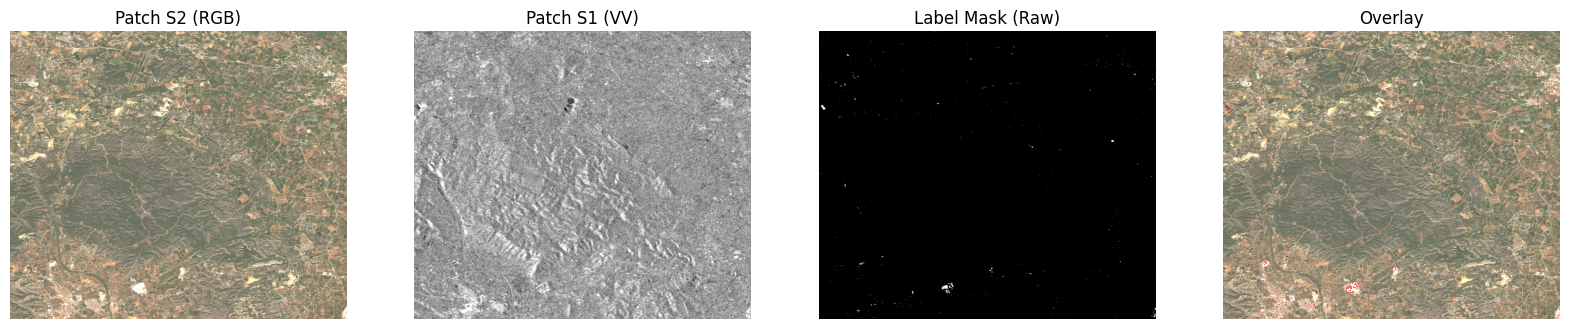

In [ ]:
# ==========================================
# 8. VISUALIZE GENERATED PATCHES
# ==========================================

if count > 0 and os.path.exists('dataset_sen12flood_v1/S2'):
    s2_dir = 'dataset_sen12flood_v1/S2'
    s1_dir = 'dataset_sen12flood_v1/S1'
    lbl_dir = 'dataset_sen12flood_v1/labels'
    
    patches = [f for f in os.listdir(s2_dir) if f.endswith('.tif')]
    
    if len(patches) > 0:
        # Show first patch
        p = patches[0]
        print(f"Visualizing Patch: {p}")
        
        with rasterio.open(os.path.join(s2_dir, p)) as src_s2:
            # S2 bands: B2, B3, B4, B8, B11, NDWI, MNDWI
            s2_data = src_s2.read()
            # RGB is usually 2, 1, 0 (B4, B3, B2)
            # Ensure valid range
            if s2_data.shape[0] >= 3:
                rgb = np.dstack((s2_data[2], s2_data[1], s2_data[0]))
                rgb = np.clip(rgb / 3000, 0, 1)
            else:
                print("Warning: Not enough bands for RGB")
                rgb = np.zeros((256, 256, 3))

        with rasterio.open(os.path.join(s1_dir, p)) as src_s1:
            # S1 bands: VV, VH, Ratio
            s1_vv = src_s1.read(1) # Band 1 is VV

        with rasterio.open(os.path.join(lbl_dir, p)) as src_lbl:
            label = src_lbl.read(1)

        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        ax[0].imshow(rgb)
        ax[0].set_title("Patch S2 (RGB)")
        ax[0].axis('off')
        
        ax[1].imshow(s1_vv, cmap='gray', vmin=-25, vmax=0)
        ax[1].set_title("Patch S1 (VV)")
        ax[1].axis('off')
        
        ax[2].imshow(label, cmap='gray')
        ax[2].set_title("Label Mask (Raw)")
        ax[2].axis('off')
        
        ax[3].imshow(rgb)
        masked_lbl = np.ma.masked_where(label == 0, label)
        ax[3].imshow(masked_lbl, cmap='autumn', alpha=0.6, interpolation='none')
        ax[3].set_title("Overlay")
        ax[3].axis('off')
        
        plt.show()
    else:
        print("No patches found in the dataset folder.")